In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv("../datasets/winequality.csv", sep=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df["quality"], test_size=0.2, random_state=42, stratify=df["quality"])

x_train.shape, x_test.shape

((3918, 11), (980, 11))

In [4]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train, y_train)

In [5]:
# baseline accuracy score
mlp.score(x_test, y_test)

0.5173469387755102

## Sequential Forward selection

In [6]:
from sklearn.neural_network import MLPClassifier

# all input features
all_features = set(df.columns) - {"quality"}

feature_selection = []
prev_acc = 0

# iterate over the size of all features
for _ in all_features:
    max_acc = []
    # iterate over the features not yet included in the selection
    for x in all_features-set(feature_selection):
        # train MLP on current selection plus feature x and evaluate its score
        mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[feature_selection+[x]], y_train)
        acc = mlp.score(x_test[feature_selection+[x]], y_test)
        max_acc.append((acc, x))

    # sort so that first element is the feature that together with
    # selection produced the highest accuracy
    max_acc.sort(key=lambda t: t[0], reverse=True)
    # if the feature with the highest accuracy did not increase the previous accuracy, then quit
    if max_acc[0][0] < prev_acc: break
    # append feature with highest accuracy 
    feature_selection.append(max_acc[0][1])
    prev_acc = max_acc[0][0]
    print(max_acc)

print(feature_selection)

[(0.5214285714285715, 'alcohol'), (0.4663265306122449, 'total sulfur dioxide'), (0.45, 'free sulfur dioxide'), (0.4489795918367347, 'chlorides'), (0.4489795918367347, 'pH'), (0.4489795918367347, 'sulphates'), (0.4489795918367347, 'density'), (0.4448979591836735, 'citric acid'), (0.44081632653061226, 'fixed acidity'), (0.44081632653061226, 'residual sugar'), (0.43673469387755104, 'volatile acidity')]
[(0.5265306122448979, 'sulphates'), (0.5255102040816326, 'citric acid'), (0.5224489795918368, 'volatile acidity'), (0.5204081632653061, 'fixed acidity'), (0.5163265306122449, 'density'), (0.513265306122449, 'free sulfur dioxide'), (0.5091836734693878, 'chlorides'), (0.49795918367346936, 'pH'), (0.4959183673469388, 'total sulfur dioxide'), (0.49081632653061225, 'residual sugar')]
[(0.5295918367346939, 'citric acid'), (0.5285714285714286, 'density'), (0.5244897959183673, 'volatile acidity'), (0.523469387755102, 'chlorides'), (0.5204081632653061, 'free sulfur dioxide'), (0.5163265306122449, 'p

In [7]:
# feature set with only ['alcohol', 'sulphates', 'citric acid'] has a similar score than with all 11 features
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[feature_selection], y_train)
mlp.score(x_test[feature_selection], y_test)

0.5295918367346939

## Sequential backward selection

In [8]:
from sklearn.neural_network import MLPClassifier

# all input features
all_features = set(df.columns) - {"quality"}

# start with every feature
feature_selection = [f for f in all_features]
prev_acc = 0

# iterate over the size of all features
for _ in all_features:
    max_acc = []
    # iterate over the selected features
    for x in feature_selection:
        # train MLP on current selection minus feature x and evaluate its score
        features = list(set(feature_selection)-{x})
        mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[features], y_train)
        acc = mlp.score(x_test[features], y_test)
        max_acc.append((acc, x))

    # sort so that first element is the feature that together with
    # selection produced the highest accuracy
    max_acc.sort(key=lambda t: t[0], reverse=True)
    # if the feature with the highest accuracy did not increase the previous accuracy, then quit
    if max_acc[0][0] < prev_acc: break 
    # append feature with highest accuracy 
    feature_selection.remove(max_acc[0][1])
    prev_acc = max_acc[0][0]
    print(max_acc)

print(feature_selection)

[(0.536734693877551, 'total sulfur dioxide'), (0.47244897959183674, 'alcohol'), (0.4489795918367347, 'citric acid'), (0.4489795918367347, 'chlorides'), (0.4489795918367347, 'pH'), (0.4489795918367347, 'sulphates'), (0.4489795918367347, 'fixed acidity'), (0.4489795918367347, 'free sulfur dioxide'), (0.4489795918367347, 'volatile acidity'), (0.4489795918367347, 'residual sugar'), (0.4489795918367347, 'density')]
[(0.5377551020408163, 'free sulfur dioxide'), (0.5346938775510204, 'pH'), (0.5346938775510204, 'sulphates'), (0.5346938775510204, 'fixed acidity'), (0.5326530612244897, 'chlorides'), (0.5306122448979592, 'density'), (0.523469387755102, 'citric acid'), (0.5193877551020408, 'residual sugar'), (0.5153061224489796, 'volatile acidity'), (0.4714285714285714, 'alcohol')]
['alcohol', 'citric acid', 'chlorides', 'pH', 'sulphates', 'fixed acidity', 'volatile acidity', 'residual sugar', 'density']


In [9]:
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(16, 8, 8), random_state=42).fit(x_train[feature_selection], y_train)
mlp.score(x_test[feature_selection], y_test)

0.5377551020408163

## Principal Component Analysis

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(x_train)
x_train_pca = pca.transform(x_train)

pca_df = pd.concat([pd.DataFrame(x_train_pca, columns=['pc1', 'pc2']), y_train.reset_index(drop=True)], axis=1)
pca_df

,pc1,pc2,quality
0,11.488598,-1.582769,7
1,-30.282346,12.836652,7
2,40.941490,15.234333,5
3,-42.018865,7.733841,6
4,-36.715222,11.569311,8
...,...,...,...
3913,44.282519,4.067258,5
3914,23.088687,-8.825600,6
3915,-12.164777,-15.972143,5
3916,-22.578244,10.704343,7


To project $X$ onto $W$ so that after projection the variance is most spread out: 
$$
    X_{proj} = W^T(X-\overline{X})
$$ 
where $W$ is the $k$-dimensional matrix consisting of $k$ eigenvectors as columns.
The variances over these $k$ dimensions are the eigenvalues, which indicate how much variance is explained by the principal components (eigenvectors) of the new transformation.

[1926.68330975  172.67902833] [1927.17518703  172.72311284]
[0.91774692 0.08225308] [0.90753353 0.08133771]


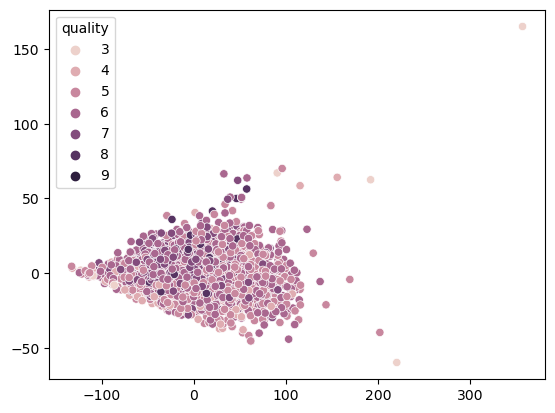

In [11]:
x_train_projected = pca.components_ @ (x_train - x_train.mean()).to_numpy().T

sns.scatterplot(x=x_train_projected[0, :], y=x_train_projected[1, :], hue=y_train)

assert np.all(x_train_projected.T == pca_df.iloc[:, :2].to_numpy()), "pca eigenvecs matrix multiplied by (x_train - x_train.mean) must equal PCA output"

explained_variance = x_train_projected.var(axis=1)
explained_variance_ratio = explained_variance/explained_variance.sum()

print(explained_variance, pca.explained_variance_) 
print(explained_variance_ratio, pca.explained_variance_ratio_)

array([0.90753353, 0.08133771])

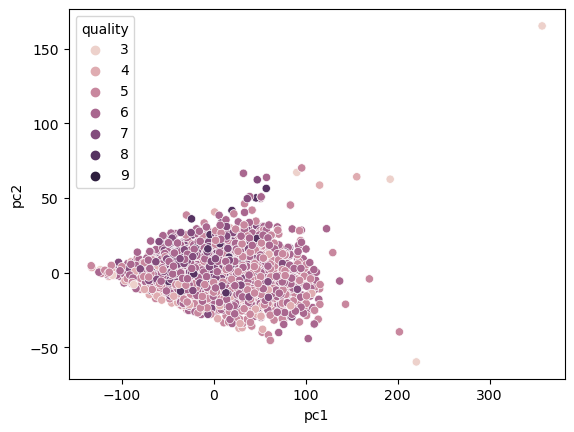

In [12]:
sns.scatterplot(pca_df, x='pc1', y='pc2', hue='quality')
pca.explained_variance_ratio_

<Axes: >

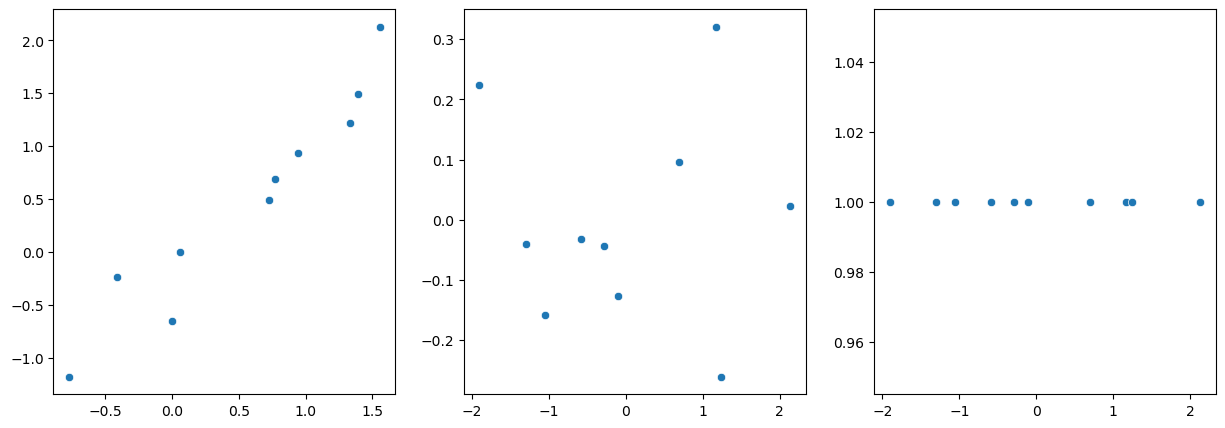

In [32]:
sample = np.random.multivariate_normal([0, 0], [[1, 0.95], [0.95, 1]], (10,))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=sample[:, 0], y=sample[:, 1], ax=axes[0])

pca = PCA(n_components=2).fit(sample)
pca_sample = pca.transform(sample)

sns.scatterplot(x=pca_sample[:, 0], y=pca_sample[:, 1], ax=axes[1])


sns.scatterplot(x=pca_sample[:, 0], y=np.ones_like(pca_sample[:, 0]), ax=axes[2])

<Axes: >

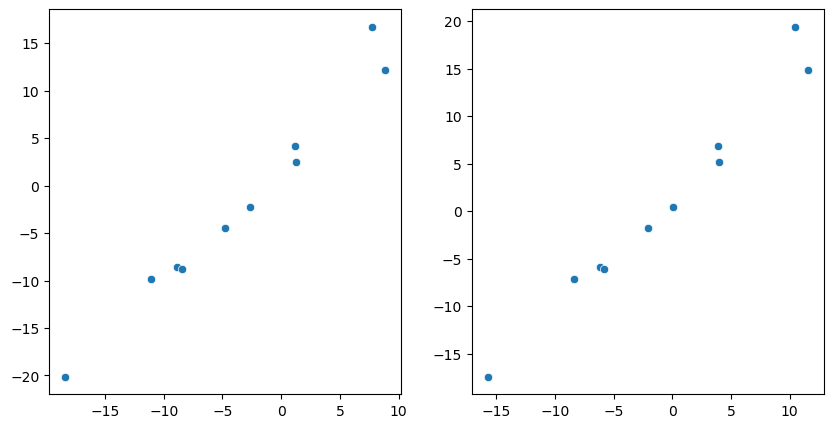

In [39]:
sample = np.random.multivariate_normal([0, 0], [[1, 0.95], [0.95, 1]], (10,)) * 10

mean = sample.mean()
de_mean_sample = sample - mean

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=sample[:, 0], y=sample[:, 1], ax=axes[0])
sns.scatterplot(x=de_mean_sample[:, 0], y=de_mean_sample[:, 1], ax=axes[1])

In [42]:


def first_principal_component(data: np.ndarray, n: int = 100, step_size: float = 0.1):
    guess = np.ones((1, data.shape[1]))
    
    for _ in range(n):
        dv = directional_variance(data, guess)
        gradient = directional_variance_gradient(data, guess)
        guess = gradient_step(guess, gradient, step_size)
    
    return direction(guess)

first_principal_component(sample)

array([[-11.05082681,  -9.86111266],
       [  8.87113002,  12.22482452],
       [ -4.78855163,  -4.45325761],
       [ -2.66264936,  -2.28662347],
       [  1.19885598,   4.15833974],
       [ -8.8545319 ,  -8.61922201],
       [  7.7240988 ,  16.7266446 ],
       [-18.3966489 , -20.13506673],
       [ -8.47117953,  -8.83197281],
       [  1.26555809,   2.49583548]])